In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# For displaying charts inline
%matplotlib inline

In [2]:
# Load average price by room type
df_price_by_room = pd.read_csv("Average Price by Room Type.csv")

# Load count of listings by full location
df_count_by_location = pd.read_csv("Count of id by FullLocation.csv")

# Load sum of listings by year
df_listings_by_year = pd.read_csv("Sum of listing_id by Year.csv")

# Load sum of prices by neighbourhood
df_price_by_neighbourhood = pd.read_csv("Sum of price by neighbourhood.csv")

# Display the shapes of each dataset to confirm loading
print("Price by Room Type:", df_price_by_room.shape)
print("Count by Location:", df_count_by_location.shape)
print("Listings by Year:", df_listings_by_year.shape)
print("Price by Neighbourhood:", df_price_by_neighbourhood.shape)


Price by Room Type: (4, 2)
Count by Location: (2, 2)
Listings by Year: (4707, 5)
Price by Neighbourhood: (38, 2)


In [3]:
# Preview each dataset
print("=== Average Price by Room Type ===")
display(df_price_by_room.head())
print("\nData Types:\n", df_price_by_room.dtypes)

print("\n=== Count of Listings by Full Location ===")
display(df_count_by_location.head())
print("\nData Types:\n", df_count_by_location.dtypes)

print("\n=== Sum of Listings by Year ===")
display(df_listings_by_year.head())
print("\nData Types:\n", df_listings_by_year.dtypes)

print("\n=== Sum of Price by Neighbourhood ===")
display(df_price_by_neighbourhood.head())
print("\nData Types:\n", df_price_by_neighbourhood.dtypes)


=== Average Price by Room Type ===


,Room Type,Average Price
0,Entire home/apt,430.78
1,Hotel room,282.39
2,Private room,136.96
3,Shared room,85.62



Data Types:
 Room Type         object
Average Price    float64
dtype: object

=== Count of Listings by Full Location ===


,FullLocation,Count of id
0,"North Sydney, Australia",698
1,"Sydney, Australia",4125



Data Types:
 FullLocation    object
Count of id      int64
dtype: object

=== Sum of Listings by Year ===


,Year,Quarter,Month,Day,Sum of listing_id
0,2010,Qtr 3,August,4,12936
1,2010,Qtr 3,September,9,47100
2,2010,Qtr 4,October,2,47100
3,2010,Qtr 4,October,9,47100
4,2010,Qtr 4,October,24,47100



Data Types:
 Year                  int64
Quarter              object
Month                object
Day                   int64
Sum of listing_id     int64
dtype: object

=== Sum of Price by Neighbourhood ===


,neighbourhood,Sum of price
0,Sydney,1190775
1,Pittwater,709659
2,Waverley,674035
3,Randwick,352681
4,Manly,339260



Data Types:
 neighbourhood    object
Sum of price      int64
dtype: object


In [4]:
# Rename columns for consistency
df_price_by_room.columns = ['room_type', 'average_price']
df_count_by_location.columns = ['location', 'listing_count']
df_listings_by_year.columns = ['year', 'quarter', 'month', 'day', 'listing_count']
df_price_by_neighbourhood.columns = ['neighbourhood', 'total_price']

# Check for missing values
print("Missing values in df_price_by_room:\n", df_price_by_room.isnull().sum(), "\n")
print("Missing values in df_count_by_location:\n", df_count_by_location.isnull().sum(), "\n")
print("Missing values in df_listings_by_year:\n", df_listings_by_year.isnull().sum(), "\n")
print("Missing values in df_price_by_neighbourhood:\n", df_price_by_neighbourhood.isnull().sum(), "\n")

# Convert date-related columns into a proper datetime format for time series
df_listings_by_year['date'] = pd.to_datetime(
    df_listings_by_year[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

# Display how many valid vs. invalid date entries we have
print("Valid dates:", df_listings_by_year['date'].notnull().sum())
print("Invalid dates (NaT):", df_listings_by_year['date'].isnull().sum())

Missing values in df_price_by_room:
 room_type        0
average_price    0
dtype: int64 

Missing values in df_count_by_location:
 location         0
listing_count    0
dtype: int64 

Missing values in df_listings_by_year:
 year             0
quarter          0
month            0
day              0
listing_count    0
dtype: int64 

Missing values in df_price_by_neighbourhood:
 neighbourhood    0
total_price      0
dtype: int64 

Valid dates: 4707
Invalid dates (NaT): 0


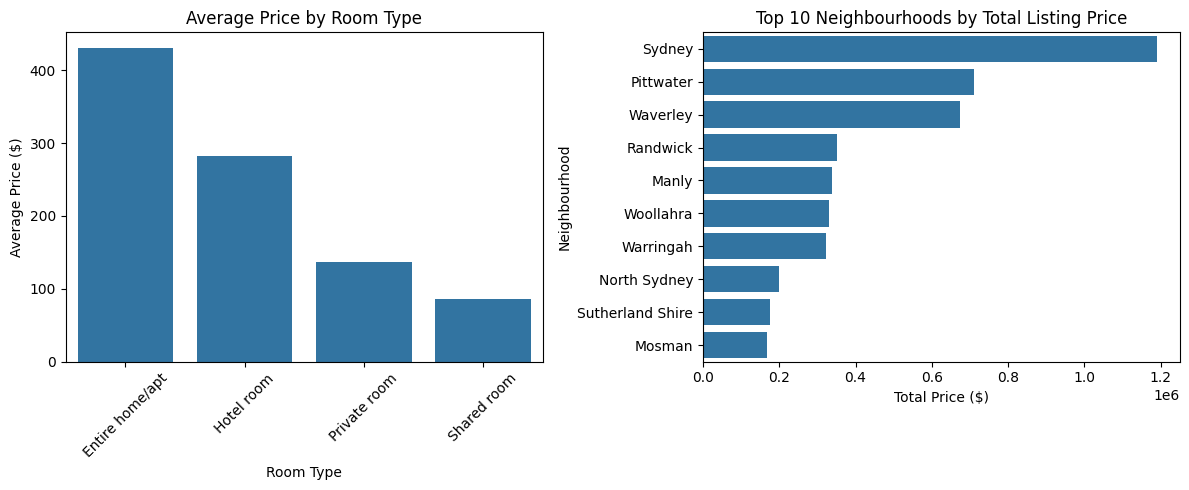

In [5]:
plt.figure(figsize=(12, 5))

# Average price by room type
plt.subplot(1, 2, 1)
sns.barplot(data=df_price_by_room, x='room_type', y='average_price')
plt.title("Average Price by Room Type")
plt.ylabel("Average Price ($)")
plt.xlabel("Room Type")
plt.xticks(rotation=45)

# Listing count by neighbourhood
plt.subplot(1, 2, 2)
top_locations = df_price_by_neighbourhood.sort_values(by='total_price', ascending=False).head(10)
sns.barplot(data=top_locations, x='total_price', y='neighbourhood')
plt.title("Top 10 Neighbourhoods by Total Listing Price")
plt.xlabel("Total Price ($)")
plt.ylabel("Neighbourhood")

plt.tight_layout()
plt.show()

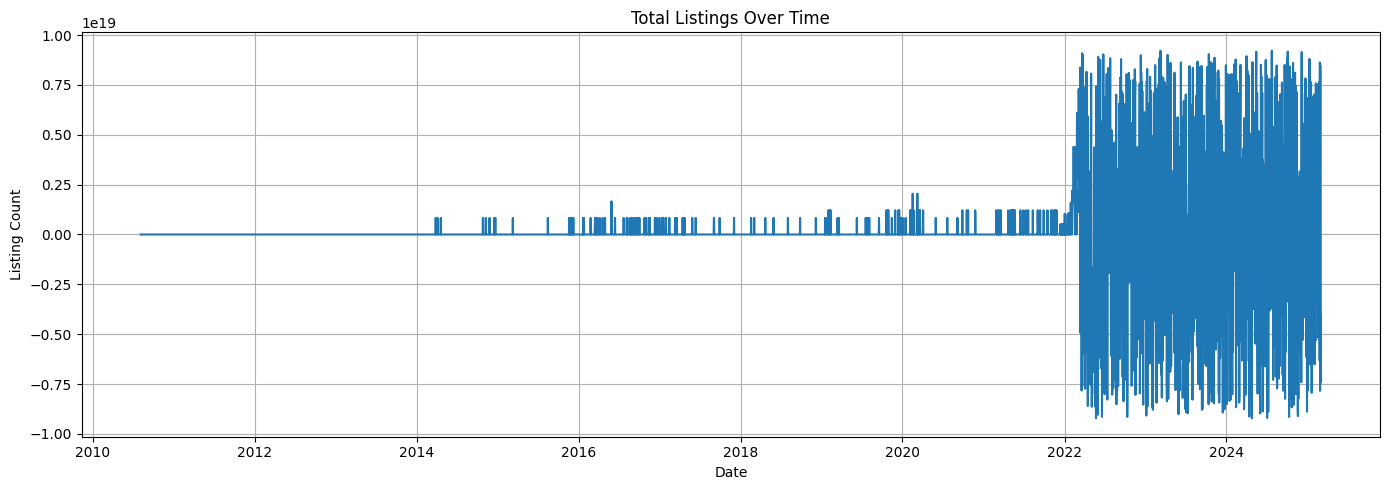

In [6]:
# Aggregate listings by date
df_time_series = df_listings_by_year.groupby('date')['listing_count'].sum().reset_index()

# Plot the time series
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_time_series, x='date', y='listing_count')
plt.title("Total Listings Over Time")
plt.xlabel("Date")
plt.ylabel("Listing Count")
plt.grid(True)
plt.tight_layout()
plt.show()

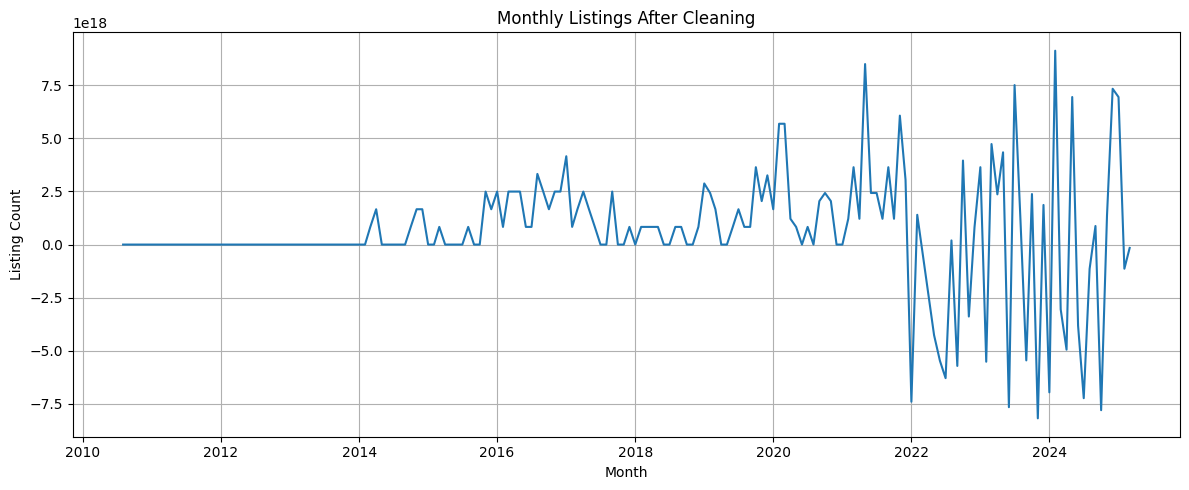

In [7]:
# Convert to monthly granularity
df_monthly = df_time_series.copy()
df_monthly['month'] = df_monthly['date'].dt.to_period('M').dt.to_timestamp()
df_monthly = df_monthly.groupby('month')['listing_count'].sum().reset_index()

# Remove extreme outliers using z-score
from scipy.stats import zscore
df_monthly['z_score'] = zscore(df_monthly['listing_count'])
df_monthly_cleaned = df_monthly[df_monthly['z_score'].abs() < 3].copy()  # Keep within 3 std deviations

# Plot the cleaned time series
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_monthly_cleaned, x='month', y='listing_count')
plt.title("Monthly Listings After Cleaning")
plt.xlabel("Month")
plt.ylabel("Listing Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Scale down listing_count to millions for realism
df_monthly_cleaned['listing_count_normalized'] = df_monthly_cleaned['listing_count'] / 1e6

# Create lag features for basic time series modeling
df_features = df_monthly_cleaned.copy()
df_features['month_num'] = np.arange(len(df_features))  # simple numeric time index

# Preview the final dataset for modeling
print(df_features[['month', 'listing_count_normalized', 'month_num']].head())

       month  listing_count_normalized  month_num
0 2010-08-01                  0.012936          0
1 2010-09-01                  0.047100          1
2 2010-10-01                  0.141300          2
3 2010-11-01                  0.183136          3
4 2010-12-01                  0.181058          4


In [9]:
# Cell 9: Export cleaned and prepared data to CSV
df_features[['month', 'listing_count_normalized', 'month_num']].to_csv("prepared_listing_data.csv", index=False)
print("Data exported successfully to 'prepared_listing_data.csv'")


Data exported successfully to 'prepared_listing_data.csv'
